## Imports

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
!pip install Unidecode
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import pickle
from collections import Counter
from html.parser import HTMLParser
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, GlobalMaxPool1D, Bidirectional, LSTM  
from keras.layers import Embedding
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5054053243922374279
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15245246022695378705
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4410510920496251414
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12484200033588559134
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Loading Data

### Loading Train and Test data

In [0]:
col_specification = [(9, 11), (11, 30000)]
data_raw = pd.read_fwf(r"/content/drive/My Drive/MS AI Project/Data/train.ft.txt", 
                       colspecs=col_specification, header=None)
data_raw.rename(columns={0:'Sentiment', 1:'Review'}, inplace=True)

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Sentiment  int64 
 1   Review     object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


### Loading GloVe

In [0]:
# Load data (deserialize)
with open(r'/content/drive/My Drive/MS AI Project/Data/embeddings_index.pickle', 'rb') as handle:
    embeddings_index = pickle.load(handle)

## Cleaning Data

In [7]:
data_raw.head()

,Sentiment,Review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


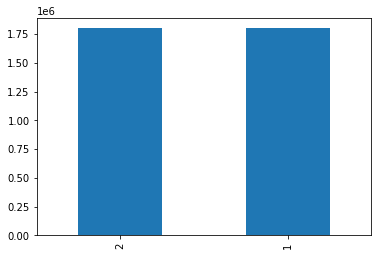

In [8]:
## Distribution of ratings
data_raw['Sentiment'].value_counts().plot(kind='bar')

In [9]:
## Checking Null values
data_raw.isna().sum()

Sentiment    0
Review       0
dtype: int64

In [0]:
## Caching words and creating a dictionary for faster removal of stopwords
stopwords = stopwords.words('english')
stopwords_dict = dict(Counter(stopwords))

### Adding new words
stopwords_dict["i'd"] = 1
stopwords_dict["i'll"] = 1

### removing these words as they help to convey negative sentiment
del stopwords_dict['not']
del stopwords_dict['no']
del stopwords_dict['nor']


## Loaded contracted words
file = open(r'/content/drive/My Drive/MS AI Project/Data/Contractions.json')
json_str = file.read()
contractions = json.loads(json_str)


## Data cleaning function
def data_processor(data, stopwords_dict=stopwords_dict, contractions=contractions):
  ## Dropping Null rows having null values in reviewText
  data_cleaned = data.loc[~data['Review'].isna()].copy()
  print("Finished removing null values...")

  ## Removing non-ascii characters
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: unidecode.unidecode(x))

  ## Removing all the urls
  pattern = r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: re.sub(pattern,' ', str(x)))
  print("Finished removing Links/Urls...")

  ## Removing HTML tags
  html_parser = HTMLParser()
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: html_parser.unescape(x))
  
  def remove_html_tags(text):
      """remove html tags from text"""
      content = BeautifulSoup(text, "html.parser")
      stripped_text = content.get_text(separator=" ")
      return stripped_text

  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: remove_html_tags(x))
  print("Finished removing HTML tags")

  ## Expanding words
  data_cleaned['Cleaned Text'] = data_cleaned['Review'].apply(lambda x: 
                                            " ".join([contractions[word] if word in contractions else word for word in x.split(" ")]))

  
  ## Removing all the puntuations & underscores
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: re.sub(r'[^\w\s\']',' ', str(x)))
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: re.sub(r'[_]',' ', str(x)))

  print("Finished removing punctuations...")

  ## Replacing all double spaces with single space
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: 
                                                     " ".join([word for word in x.split(" ") if word != ""]))
  print("Finished removing extra spaces...")

  ## Removing new line characters
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: re.sub(r'\n',' ', str(x)))
  print("Finished removing new line charaters...")

  ## Converting the review to lower case
  data_cleaned['Review'] = data_cleaned['Review'].apply(lambda x: x.lower())
  print("Converting to lower case...")

  ## Getting word count for each review 
  data_cleaned['Word Count'] = data_cleaned['Review'].apply(lambda x: len(x.split(" ")))
  print("Getting word count for each review...")

  ## Distribution of word count
  plt.figure(figsize=(12,8))
  sns.distplot(data_cleaned['Word Count'])

  ## Removing stop words from text
  data_cleaned['Cleaned Text'] = data_cleaned['Review'].apply(
                                lambda x: " ".join([word for word in x.split(" ") if word.strip() not in stopwords_dict]))
  
  ## Final Word count
  data_cleaned['Final Word Count'] = data_cleaned['Cleaned Text'].apply(lambda x: len(x.split(" ")))
  
  return data_cleaned

Finished removing null values...
Finished removing Links/Urls...
Finished removing HTML tags
Finished removing punctuations...
Finished removing extra spaces...
Finished removing new line charaters...
Converting to lower case...
Getting word count for each review...


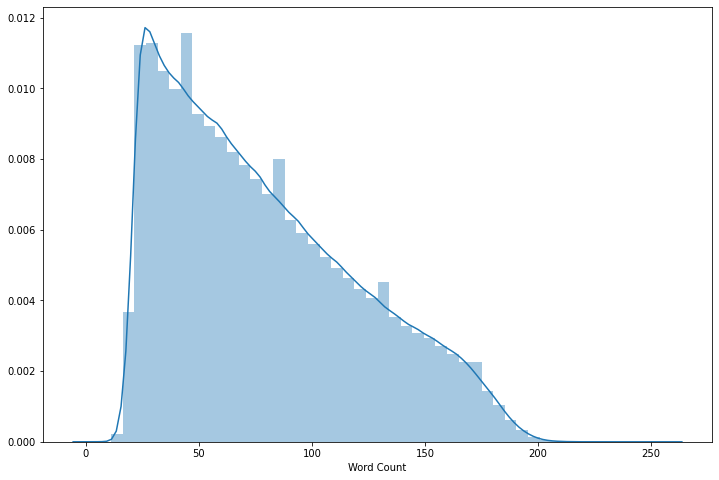

In [11]:
data_cleaned = data_processor(data_raw)

### Yet more cleaning

In [12]:
### Removing reviews that have Gibberish words
data_cleaned['English Word Count'] = data_cleaned['Cleaned Text'].apply(lambda x: 
                                                                        (sum([True for word in x.split(" ") if word in embeddings_index.keys()])))
data_cleaned['Clean Ratio'] = data_cleaned['English Word Count']/data_cleaned['Final Word Count']

print(f"Removing {len(data_cleaned.loc[data_cleaned['Clean Ratio'] < 0.2])} reviews...")
data_cleaned = data_cleaned.loc[~(data_cleaned['Clean Ratio'] < 0.2)].copy()

Removing 49 reviews...


## Preparing data for Model

In [0]:
## Creating review and seniment list
review = list(data_cleaned['Cleaned Text'])
sentiment = list(data_cleaned['Sentiment'])

In [0]:
## One-hot encoding Sentiment
sentiment_map = {1:0, 2:1}
sentiment_labels = list(map(sentiment_map.get, sentiment))
sentiment_labels = to_categorical(sentiment_labels)

In [0]:
## Preparing tokenizer
tokener = Tokenizer()
tokener.fit_on_texts(review)

In [16]:
## Setting vocab size
vocab_size = len(tokener.word_index) + 1
print(f"Number of nuique words {vocab_size}")

Number of nuique words 1070266


In [0]:
## Replacing words with interger index
encoded_review = tokener.texts_to_sequences(review)

In [0]:
## Setting Maximum length and padding if necessary
max_length = 200
padded_review = pad_sequences(encoded_review, maxlen=max_length, padding='post', truncating='post')

In [0]:
## Creating the embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokener.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
del data_raw
del data_cleaned
del review
del sentiment

## Defining model and training

In [0]:
# Define model - Epochs  30
model = Sequential(name='LSTM-CNN')

# Layer 1: Embedding layer
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False, name='embedding'))

# Layer 2: 1D Convolutional Layer
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,)))

# # Layer 3: Bi-Directional LSTM
model.add(Conv1D(filters = 100, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu'))
model.add(Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
model.add(GlobalMaxPool1D())

# Layer 4: Output Layer
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "LSTM-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          321079800 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          439296    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          128100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 64)           19264     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 321,666,590
Trainable params: 586,790
Non-trainable params: 321,079,800
______________________________________

In [0]:
# Training the model
training_log = model.fit(padded_review, sentiment_labels, validation_split=0.05, batch_size=2048, epochs=10, verbose=1)

Train on 3419953 samples, validate on 179998 samples
Epoch 1/10
3419953/3419953 [==============================] - 1060s 310us/step - loss: 0.2893 - accuracy: 0.8762 - val_loss: 0.2289 - val_accuracy: 0.9069
Epoch 2/10
3419953/3419953 [==============================] - 1053s 308us/step - loss: 0.2251 - accuracy: 0.9089 - val_loss: 0.2017 - val_accuracy: 0.9200
Epoch 3/10
3419953/3419953 [==============================] - 1051s 307us/step - loss: 0.2096 - accuracy: 0.9163 - val_loss: 0.1925 - val_accuracy: 0.9241
Epoch 4/10
3419953/3419953 [==============================] - 1052s 308us/step - loss: 0.2007 - accuracy: 0.9205 - val_loss: 0.1861 - val_accuracy: 0.9267
Epoch 5/10
3419953/3419953 [==============================] - 1053s 308us/step - loss: 0.1941 - accuracy: 0.9233 - val_loss: 0.1804 - val_accuracy: 0.9296
Epoch 6/10
3419953/3419953 [==============================] - 1051s 307us/step - loss: 0.1888 - accuracy: 0.9258 - val_loss: 0.1765 - val_accuracy: 0.9317
Epoch 7/10
341995

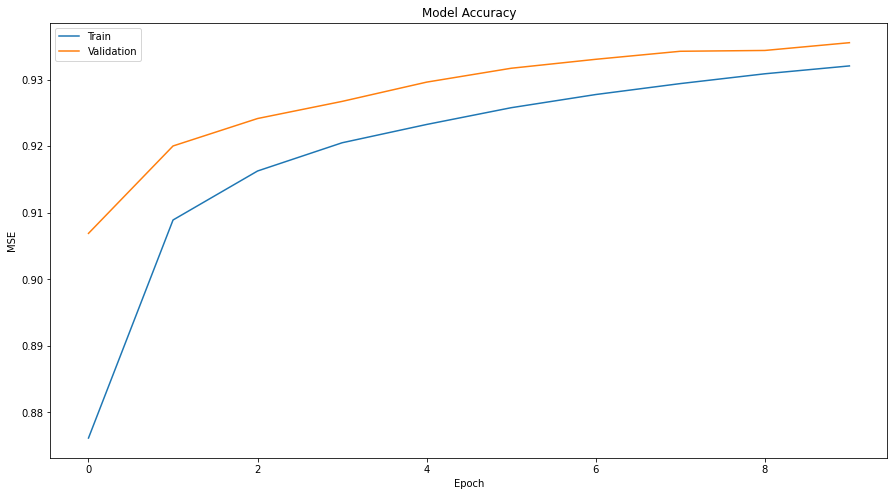

In [0]:
plt.figure(figsize=(15,8))
plt.plot(training_log.history['accuracy'])
plt.plot(training_log.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
## Saving model
model.save('/content/drive/My Drive/MS AI Project/Data/LSTM_CNN_Embedding.h5')

## Evaluating model on Test set

### Loading Model

In [21]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/MS AI Project/Data/LSTM_CNN_Embedding.h5')
model.summary()

Model: "LSTM-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          321079800 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          439296    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          128100    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 64)           19264     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 321,666,590
Trainable params: 586,790
Non-trainable params: 321,079,800
______________________________________

### Loading Test data

In [0]:
col_specification = [(9, 11), (11, 30000)]
test_data_raw = pd.read_fwf(r"/content/drive/My Drive/MS AI Project/Data/test.ft.txt", 
                       colspecs=col_specification, header=None)
test_data_raw.rename(columns={0:'Sentiment', 1:'Review'}, inplace=True)

### Preprocessing Test Data

Finished removing null values...
Finished removing Links/Urls...
Finished removing HTML tags
Finished removing punctuations...
Finished removing extra spaces...
Finished removing new line charaters...
Converting to lower case...
Getting word count for each review...


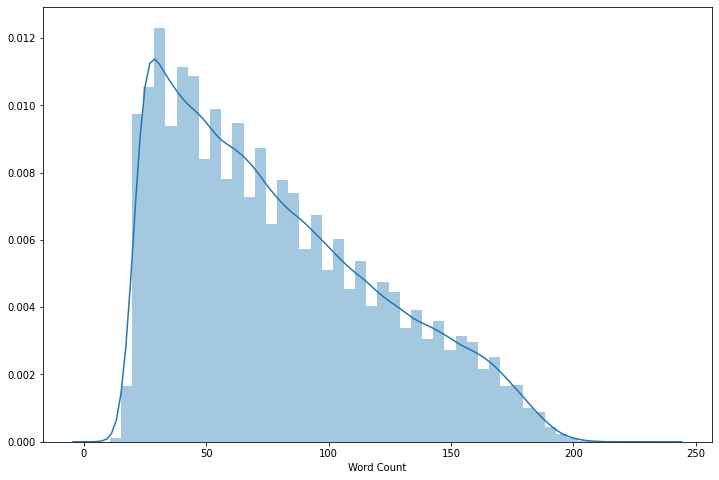

In [23]:
data_test_cleaned = data_processor(test_data_raw)

In [0]:
## Creating review and seniment list
review_test = list(data_test_cleaned['Cleaned Text'])
sentiment_test = list(data_test_cleaned['Sentiment'])

In [0]:
## One-hot encoding Sentiment
sentiment_map = {1:0, 2:1}
sentiment_test_labels = list(map(sentiment_map.get, sentiment_test))
sentiment_test_labels = to_categorical(sentiment_test_labels)

In [0]:
## Replacing words with interger index
encoded_review_test = tokener.texts_to_sequences(review_test)

In [0]:
## Applying padding
padded_review_test = pad_sequences(encoded_review_test, maxlen=max_length, padding='post', truncating='post')

### Evaluating

In [28]:
loss, accuracy = model.evaluate(padded_review_test, sentiment_test_labels, use_multiprocessing=True)

400000/400000 [==============================] - 973s 2ms/step


In [29]:
print(f"The test accuracy is {accuracy}")

The test accuracy is 0.9339050054550171
